In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import struct
from statsmodels.regression.linear_model import yule_walker
from numba import njit
from scipy.signal import butter, filtfilt, firls, iircomb

In [2]:
# =========================================================================
# NÚCLEO DE ALTO RENDIMIENTO (Compilado con Numba)
# =========================================================================
@njit(fastmath=True)
def _core_kalman_loops(y_lp, audio_1, theta_init, Q_param, R_param, Q_sig_base, R_sig, P_theta_init, P_x_init):
    N = len(audio_1)
    
    # --- Pre-alocación de memoria (Crucial para velocidad) ---
    # Para Filtro 1 (Parámetros)
    a1_est = np.zeros(N)
    a2_est = np.zeros(N)
    theta_hat = theta_init.copy()
    P_theta = P_theta_init.copy()
    
    # Para Filtro 2 (Señal) y Smoother
    X_hat_store = np.zeros((N, 2, 1))
    X_pred_store = np.zeros((N, 2, 1))
    P_x_store = np.zeros((N, 2, 2))
    P_pred_store = np.zeros((N, 2, 2))
    A_matrices = np.zeros((N, 2, 2))
    
    # Estado inicial Filtro 2
    X_hat = np.zeros((2, 1))
    P_x = P_x_init.copy()
    
    # Matrices constantes
    I2 = np.eye(2)
    C = np.array([[1.0, 0.0]])  # 1x2
    
    # =====================================================================
    # PASO 2: PRIMER FILTRO DE KALMAN (Parámetros)
    # =====================================================================
    for n in range(2, N):
        # 1. Predicción
        theta_pred = theta_hat
        P_theta_pred = P_theta + Q_param
        
        # 2. Observación H = [y(n-1), y(n-2)]^T
        # Construcción manual para evitar overhead de np.array
        H_n = np.zeros((2, 1))
        H_n[0, 0] = y_lp[n-1]
        H_n[1, 0] = y_lp[n-2]
        
        # 3. Ganancia
        # S = H.T * P * H + R (Escalar)
        PH = np.dot(P_theta_pred, H_n)
        S = np.dot(H_n.T, PH)[0, 0] + R_param
        K = PH / S
        
        # 4. Actualización
        innovation = y_lp[n] - np.dot(H_n.T, theta_pred)[0, 0]
        theta_hat = theta_pred + K * innovation
        
        # P = (I - K*H.T) * P_pred
        KH_T = np.dot(K, H_n.T)
        P_theta = np.dot((I2 - KH_T), P_theta_pred)
        
        # Guardar
        a1_est[n] = theta_hat[0, 0]
        a2_est[n] = theta_hat[1, 0]

    # =====================================================================
    # PASO 3: SEGUNDO FILTRO DE KALMAN (Señal)
    # =====================================================================
    for n in range(2, N):
        # Construir A(n)
        A_n = np.zeros((2, 2))
        A_n[0, 0] = a1_est[n]
        A_n[0, 1] = a2_est[n]
        A_n[1, 0] = 1.0
        A_matrices[n] = A_n
        
        # --- Predicción ---
        X_pred = np.dot(A_n, X_hat)
        P_x_pred = np.dot(np.dot(A_n, P_x), A_n.T) + Q_sig_base
        
        # Guardar (A priori)
        X_pred_store[n] = X_pred
        P_pred_store[n] = P_x_pred
        
        # --- Actualización ---
        y_obs = audio_1[n]
        
        # S = C * P * C.T + R
        PC_T = np.dot(P_x_pred, C.T) # 2x1
        S = np.dot(C, PC_T)[0, 0] + R_sig
        K = PC_T / S
        
        innovation = y_obs - np.dot(C, X_pred)[0, 0]
        X_hat = X_pred + K * innovation
        
        KC = np.dot(K, C) # 2x2
        P_x = np.dot((I2 - KC), P_x_pred)
        
        # Guardar (A posteriori)
        X_hat_store[n] = X_hat
        P_x_store[n] = P_x

    # =====================================================================
    # PASO 4: KALMAN SMOOTHER (RTS)
    # =====================================================================
    X_smooth = np.zeros((N, 2, 1))
    
    # Inicializar el último paso
    X_smooth[N-1] = X_hat_store[N-1]
    
    # Iterar hacia atrás
    for k in range(N - 2, -1, -1):
        P_curr = P_x_store[k]
        A_next = A_matrices[k+1]
        P_pred_next = P_pred_store[k+1]
        
        # Inversa rápida manual 2x2 para velocidad
        # Inv([[a,b],[c,d]]) = 1/(ad-bc) * [[d,-b],[-c,a]]
        a, b = P_pred_next[0, 0], P_pred_next[0, 1]
        c, d = P_pred_next[1, 0], P_pred_next[1, 1]
        det = a*d - b*c
        
        if abs(det) < 1e-12:
            inv_P = np.eye(2) # Fallback seguro
        else:
            inv_P = np.zeros((2, 2))
            inv_P[0, 0] = d
            inv_P[0, 1] = -b
            inv_P[1, 0] = -c
            inv_P[1, 1] = a
            inv_P /= det

        # S = P_k * A.T * P_{k+1|k}^-1
        S_matrix = np.dot(np.dot(P_curr, A_next.T), inv_P)
        
        # x_k^s = x_k + S * (x_{k+1}^s - x_{k+1}^-)
        diff = X_smooth[k+1] - X_pred_store[k+1]
        X_smooth[k] = X_hat_store[k] + np.dot(S_matrix, diff)

    # Extraer señal
    denoised = np.zeros(N)
    for i in range(2, N):
        denoised[i] = X_smooth[i][0, 0]
        
    return denoised

# =========================================================================
# FUNCIÓN ENVOLTORIO (API PÚBLICA)
# =========================================================================
def ecg_kalman_denoising_optimized(audio_1, fs):
    """
    Versión optimizada con Numba del algoritmo de Nazemi et al. (2021).
    Acelera los bucles de Kalman reduciendo el tiempo de ejecución drásticamente.
    """
    N = len(audio_1)
    
    # 1. Pre-procesamiento (scipy no es compatible con njit, se hace fuera)
    f1, f2 = 0.5, 150.0
    trans = 10.0
    numtaps = 251
    bands = [0.0,  f1, f2, fs / 2.0]
    desired = [0.0, 2.0, 2.0, 0.0]
    h = firls(numtaps, bands, desired, fs=fs)
    y_lp = filtfilt(h, 1.0, audio_1)
    
    # 2. Inicialización Yule-Walker (fuera de njit)
    rho, sigma = yule_walker(y_lp[:250], order=2, method="adjusted", demean=True)
    theta_init = np.array([[rho[0]], [rho[1]]])
    
    # 3. Definición de Hiperparámetros
    q_param_std = 1e-1
    r_param_std = 0.1
    Q_param = np.eye(2) * (q_param_std**2)
    R_param = r_param_std**2
    P_theta_init = np.eye(2) * 1.0
    
    q_sig_std = 1e-3
    r_noise_std = np.std(audio_1[:1000]) * 0.5
    Q_sig_base = np.array([[1.0, 0.0], [0.0, 0.0]]) * (q_sig_std**2)
    R_sig = r_noise_std**2
    P_x_init = np.eye(2) * 0.1
    
    # 4. Llamada al Núcleo Compilado
    # Aseguramos que los arrays sean float64 contiguos para C
    y_lp = np.ascontiguousarray(y_lp, dtype=np.float64)
    audio_1 = np.ascontiguousarray(audio_1, dtype=np.float64)
    
    denoised_signal = _core_kalman_loops(
        y_lp, audio_1, theta_init, 
        Q_param, R_param, Q_sig_base, R_sig, 
        P_theta_init, P_x_init
    )
    
    return denoised_signal

Header parsed successfully!
Sampling Rate: 500 Hz
Channels: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'CM5', 'CR5']
Data starts at byte: 4096
ECG Signal Shape: (1933917, 14)


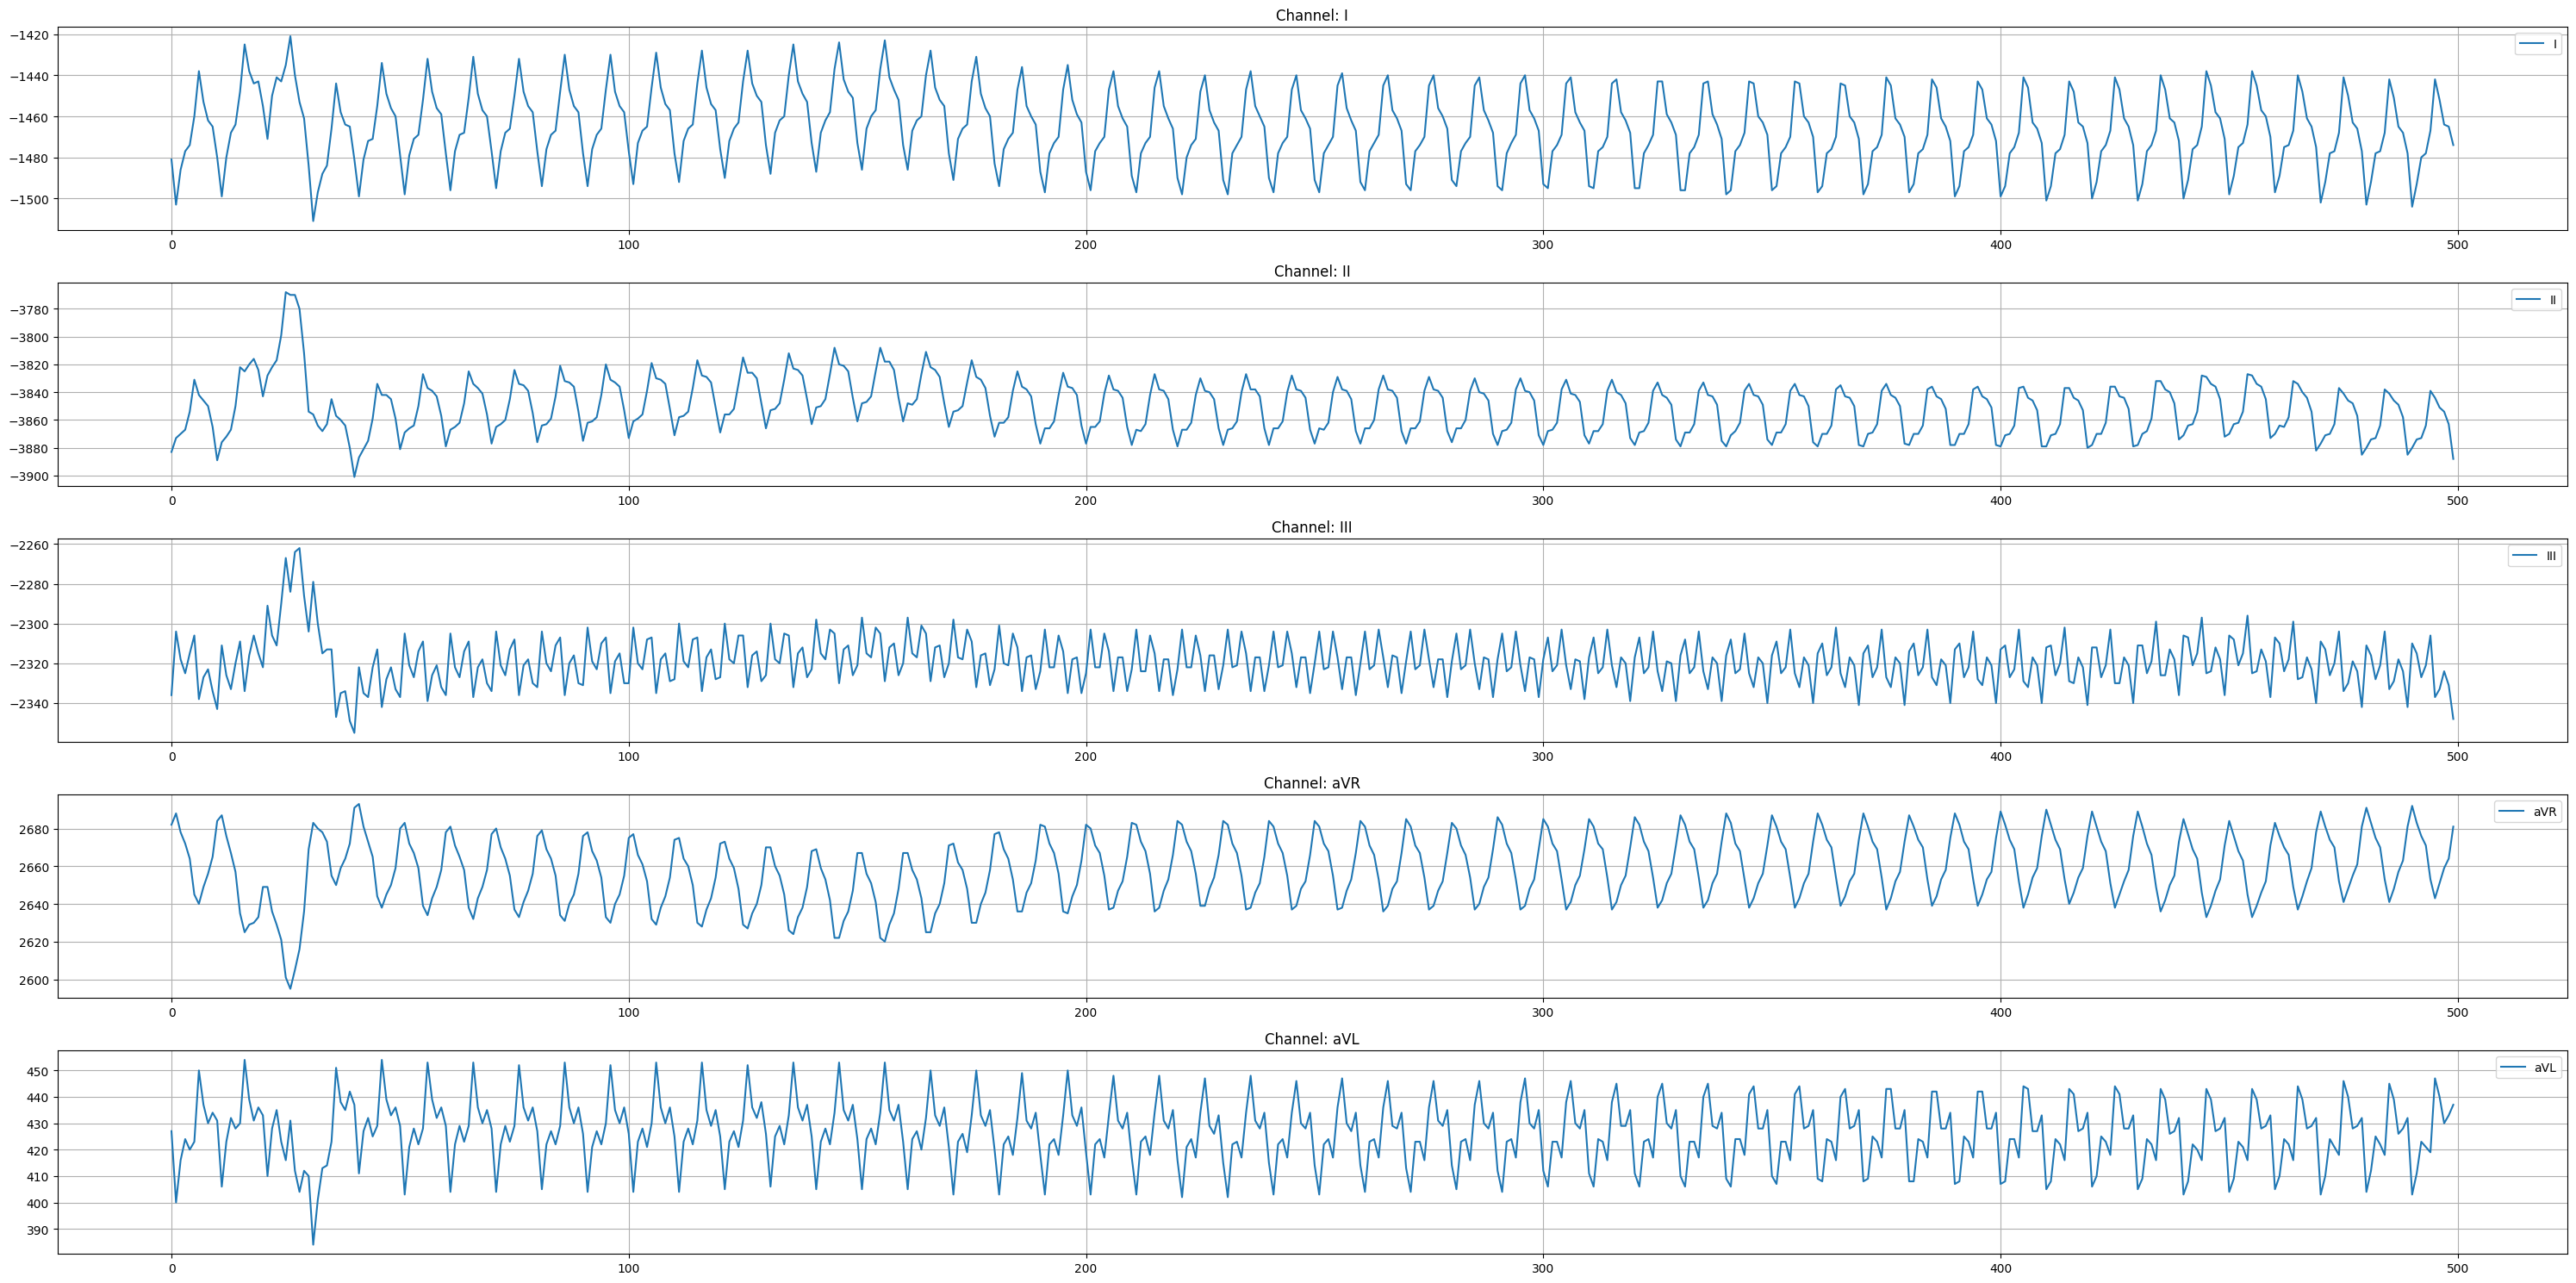

In [3]:
path = 'mediciones_simultaneas/DAVID281125-JORGE-20051201005234/bmecg'

with open(path, 'rb') as f:
    raw_data = f.read()

# 1. Parse the Header
# The file starts with "BMECG1" followed by a JSON object
header_start = 6  # Skip "BMECG1"
header_end = raw_data.find(b'}}') + 2
header_json = raw_data[header_start:header_end].decode('utf-8')
header = json.loads(header_json)

print("Header parsed successfully!")
print(f"Sampling Rate: {header['ecg']['samplingRate']} Hz")
print(f"Channels: {header['ecg']['channels']}")

# 2. Find Data Start
# Skip null bytes padding after the JSON header
data_start = header_end
while data_start < len(raw_data) and raw_data[data_start] == 0:
    data_start += 1

print(f"Data starts at byte: {data_start}")

# 3. Read Signal Data
# 'short' format usually means 16-bit signed integer (int16)
num_channels = len(header['ecg']['channels'])
signal_data = np.frombuffer(raw_data, dtype=np.int16, offset=data_start)

# Reshape data: (Samples, Channels)
# We truncate any extra bytes that don't fit perfectly into the shape
num_samples = len(signal_data) // num_channels
signal_data = signal_data[:num_samples * num_channels]
ecg_signal = signal_data.reshape(num_samples, num_channels)

print(f"ECG Signal Shape: {ecg_signal.shape}")

# 4. Plot the first 5 channels to verify
plt.figure(figsize=(30, 15))
for i in range(5):
    plt.subplot(5, 1, i+1)
    # Added label to fix UserWarning
    plt.plot(ecg_signal[500000:500500, i], label=header['ecg']['channels'][i])
    plt.title(f"Channel: {header['ecg']['channels'][i]}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
#plt.savefig('ecg_channels_plot.png')
plt.show()
# save figure


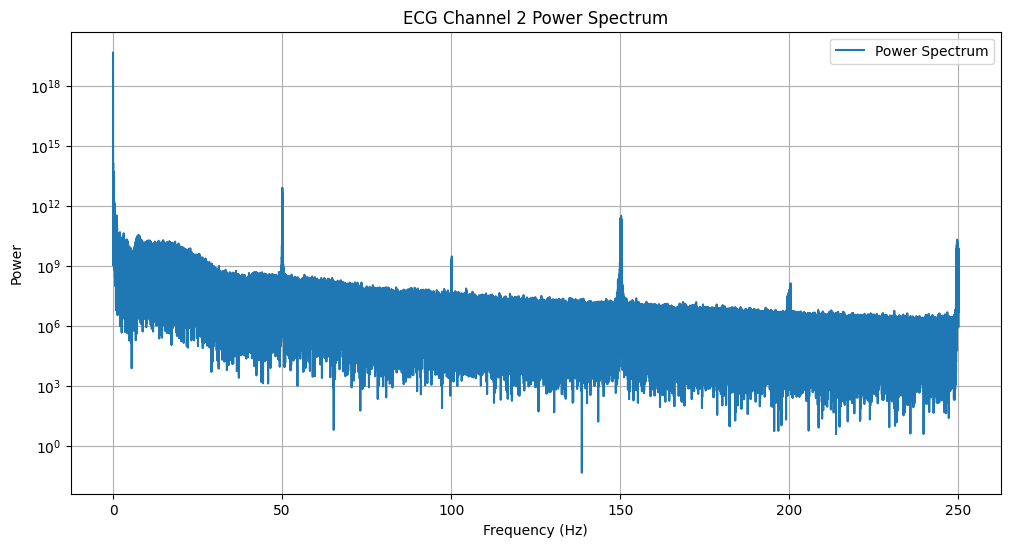

In [4]:
ecg_fft = np.fft.fft(ecg_signal[:,1])  # FFT of the second channel
freqs = np.linspace(0, header['ecg']['samplingRate']/2, len(ecg_fft)//2 + 1)
ecg_fft = np.abs(ecg_fft[:len(freqs)])**2

plt.figure(figsize=(12, 6))
plt.plot(freqs, ecg_fft, label='Power Spectrum')
plt.yscale('log')
plt.grid(True)
plt.title('ECG Channel 2 Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()

In [5]:
# bandpass filter between 0.5 Hz and 150 Hz for ECG signal channel 2
lowcut = 0.5
highcut = 150.0
fs = header['ecg']['samplingRate']
order = 4
b, a = butter(order, [lowcut, highcut], btype='bandpass', fs=fs)
b2, a2 = butter(order+1, [lowcut, highcut], btype='bandpass', fs=fs)
b3, a3 = butter(order+2, [lowcut, highcut], btype='bandpass', fs=fs)

# comb filter at w0=50 Hz to remove powerline noise
w0 = 50.0  # Frequency to be removed from signal (Hz)
quality_factor = 30.0  # Quality factor
b_notch, a_notch = iircomb(w0, quality_factor, ftype='notch', fs=fs)

filtered_ecg = filtfilt(b_notch, a_notch, ecg_signal[:,1])
filtered_ecg = ecg_kalman_denoising_optimized(filtered_ecg, fs)
filtered_ecg = filtfilt(b, a, filtered_ecg)



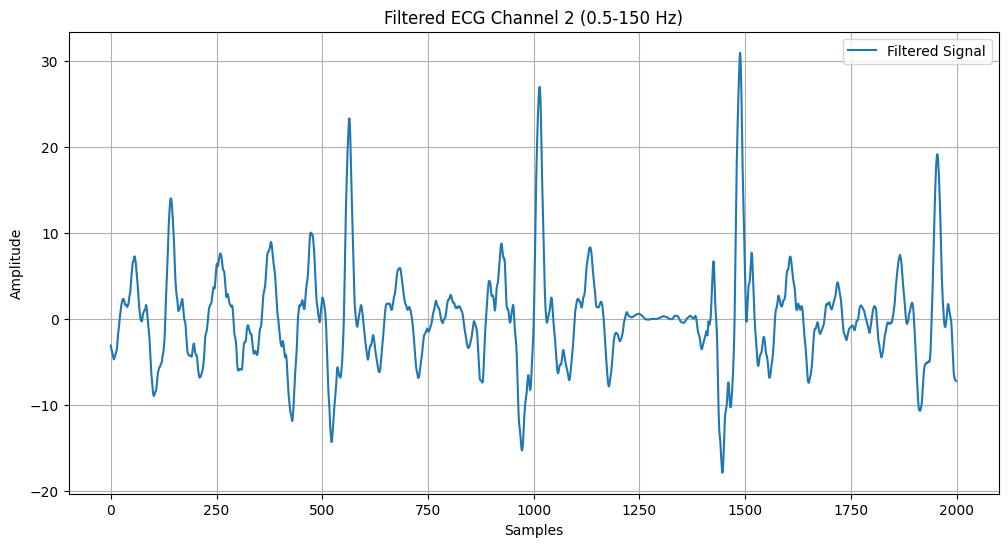

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_ecg[250000:252000], label='Filtered Signal')
plt.title('Filtered ECG Channel 2 (0.5-150 Hz)')
plt.grid(True)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

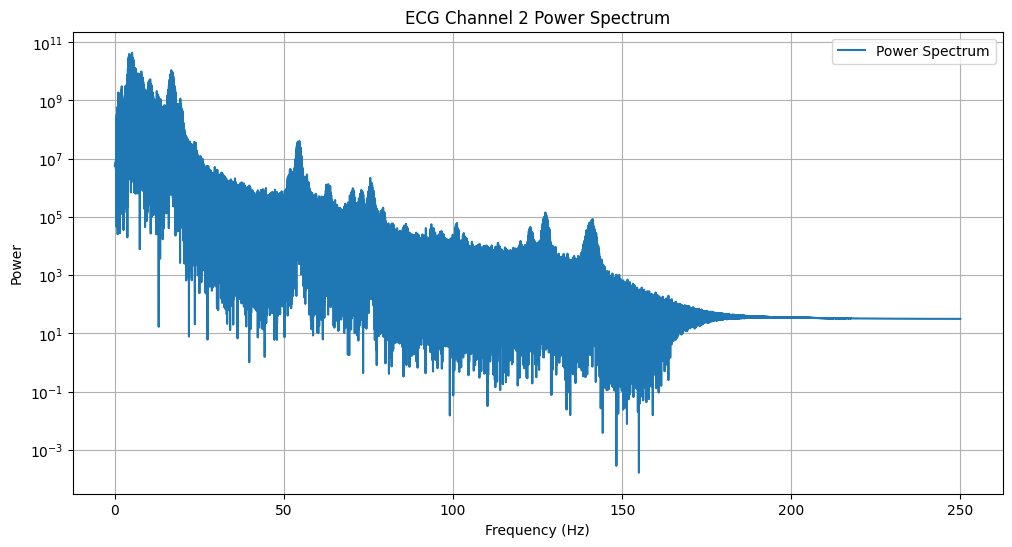

In [7]:
filtered_ecg_fft = np.fft.fft(filtered_ecg)  # FFT of the filtered second channel
freqs = np.linspace(0, header['ecg']['samplingRate']/2, len(filtered_ecg_fft)//2 + 1)
power_spectrum = np.abs(filtered_ecg_fft[:len(freqs)])**2

plt.figure(figsize=(12, 6))
plt.plot(freqs, power_spectrum[:len(freqs)], label='Power Spectrum')
plt.yscale('log')
plt.grid(True)
plt.title('ECG Channel 2 Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()